## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from sklearn.datasets import make_moons

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Raw Data

In [2]:
x, y = make_moons(noise=0.3, random_state=0)

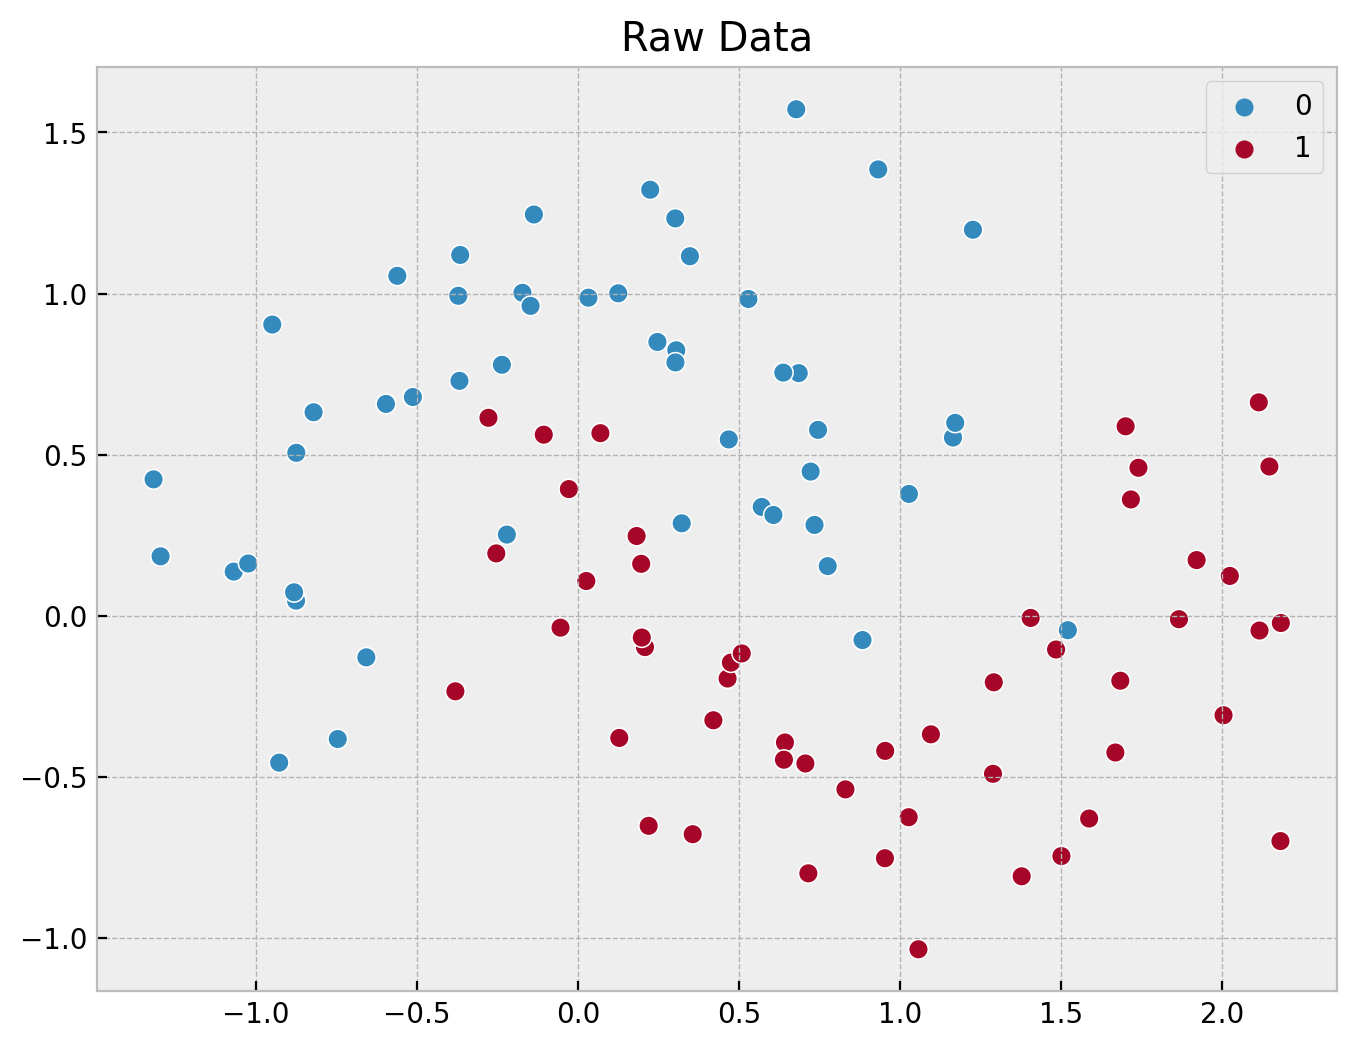

In [3]:
fig, ax = plt.subplots()
sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, hue=y, ax=ax)
ax.set(title="Raw Data");

## Linear Model

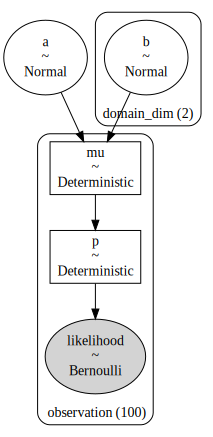

In [4]:
coords = {
    "observation": np.arange(x.shape[0]),
    "domain_dim": np.arange(x.shape[1]),
}

with pm.Model(coords=coords) as linear_model:
    # priors
    a = pm.Normal(name="a", mu=0, sigma=2)
    b = pm.Normal(name="b", mu=0, sigma=2, dims="domain_dim")
    # model parametrization
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x, b) + a, dims="observation")
    p = pm.Deterministic(name="p", var=pm.math.sigmoid(mu), dims="observation")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="observation", observed=y)

pm.model_to_graphviz(model=linear_model)

In [5]:
with linear_model:
    linear_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_idata)

Compiling...
Compilation time =  0:00:03.893935
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:05.093364
Transforming variables...
Transformation time =  0:00:00.285272
Computing Log Likelihood...
Log Likelihood time =  0:00:00.736521


In [6]:
az.summary(data=linear_idata, var_names=["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.108,0.351,-0.561,0.765,0.003,0.003,10253.0,10570.0,1.0
b[0],1.406,0.368,0.706,2.083,0.004,0.003,10899.0,9526.0,1.0
b[1],-3.357,0.690,-4.669,-2.086,0.007,0.005,11286.0,9096.0,1.0


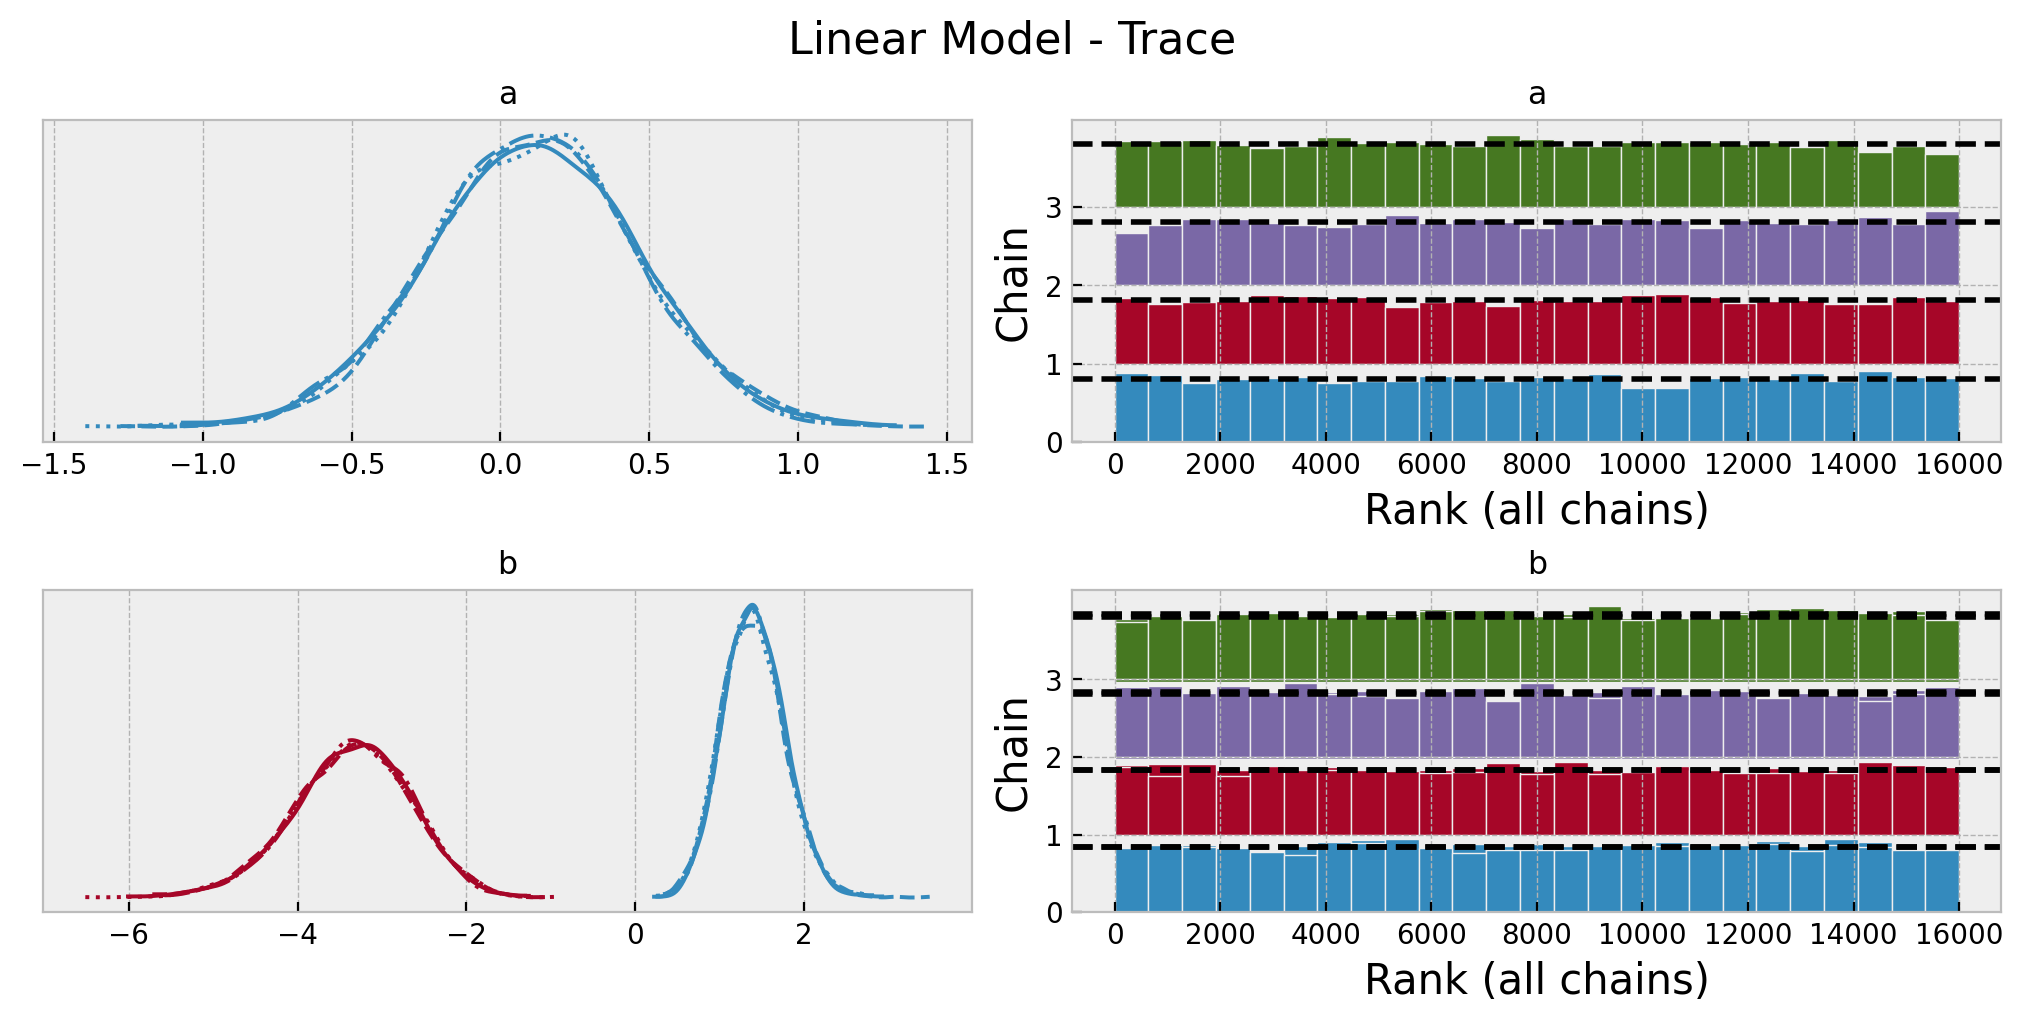

In [7]:
axes = az.plot_trace(
    data=linear_idata,
    var_names=["a", "b"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Model - Trace", fontsize=16);

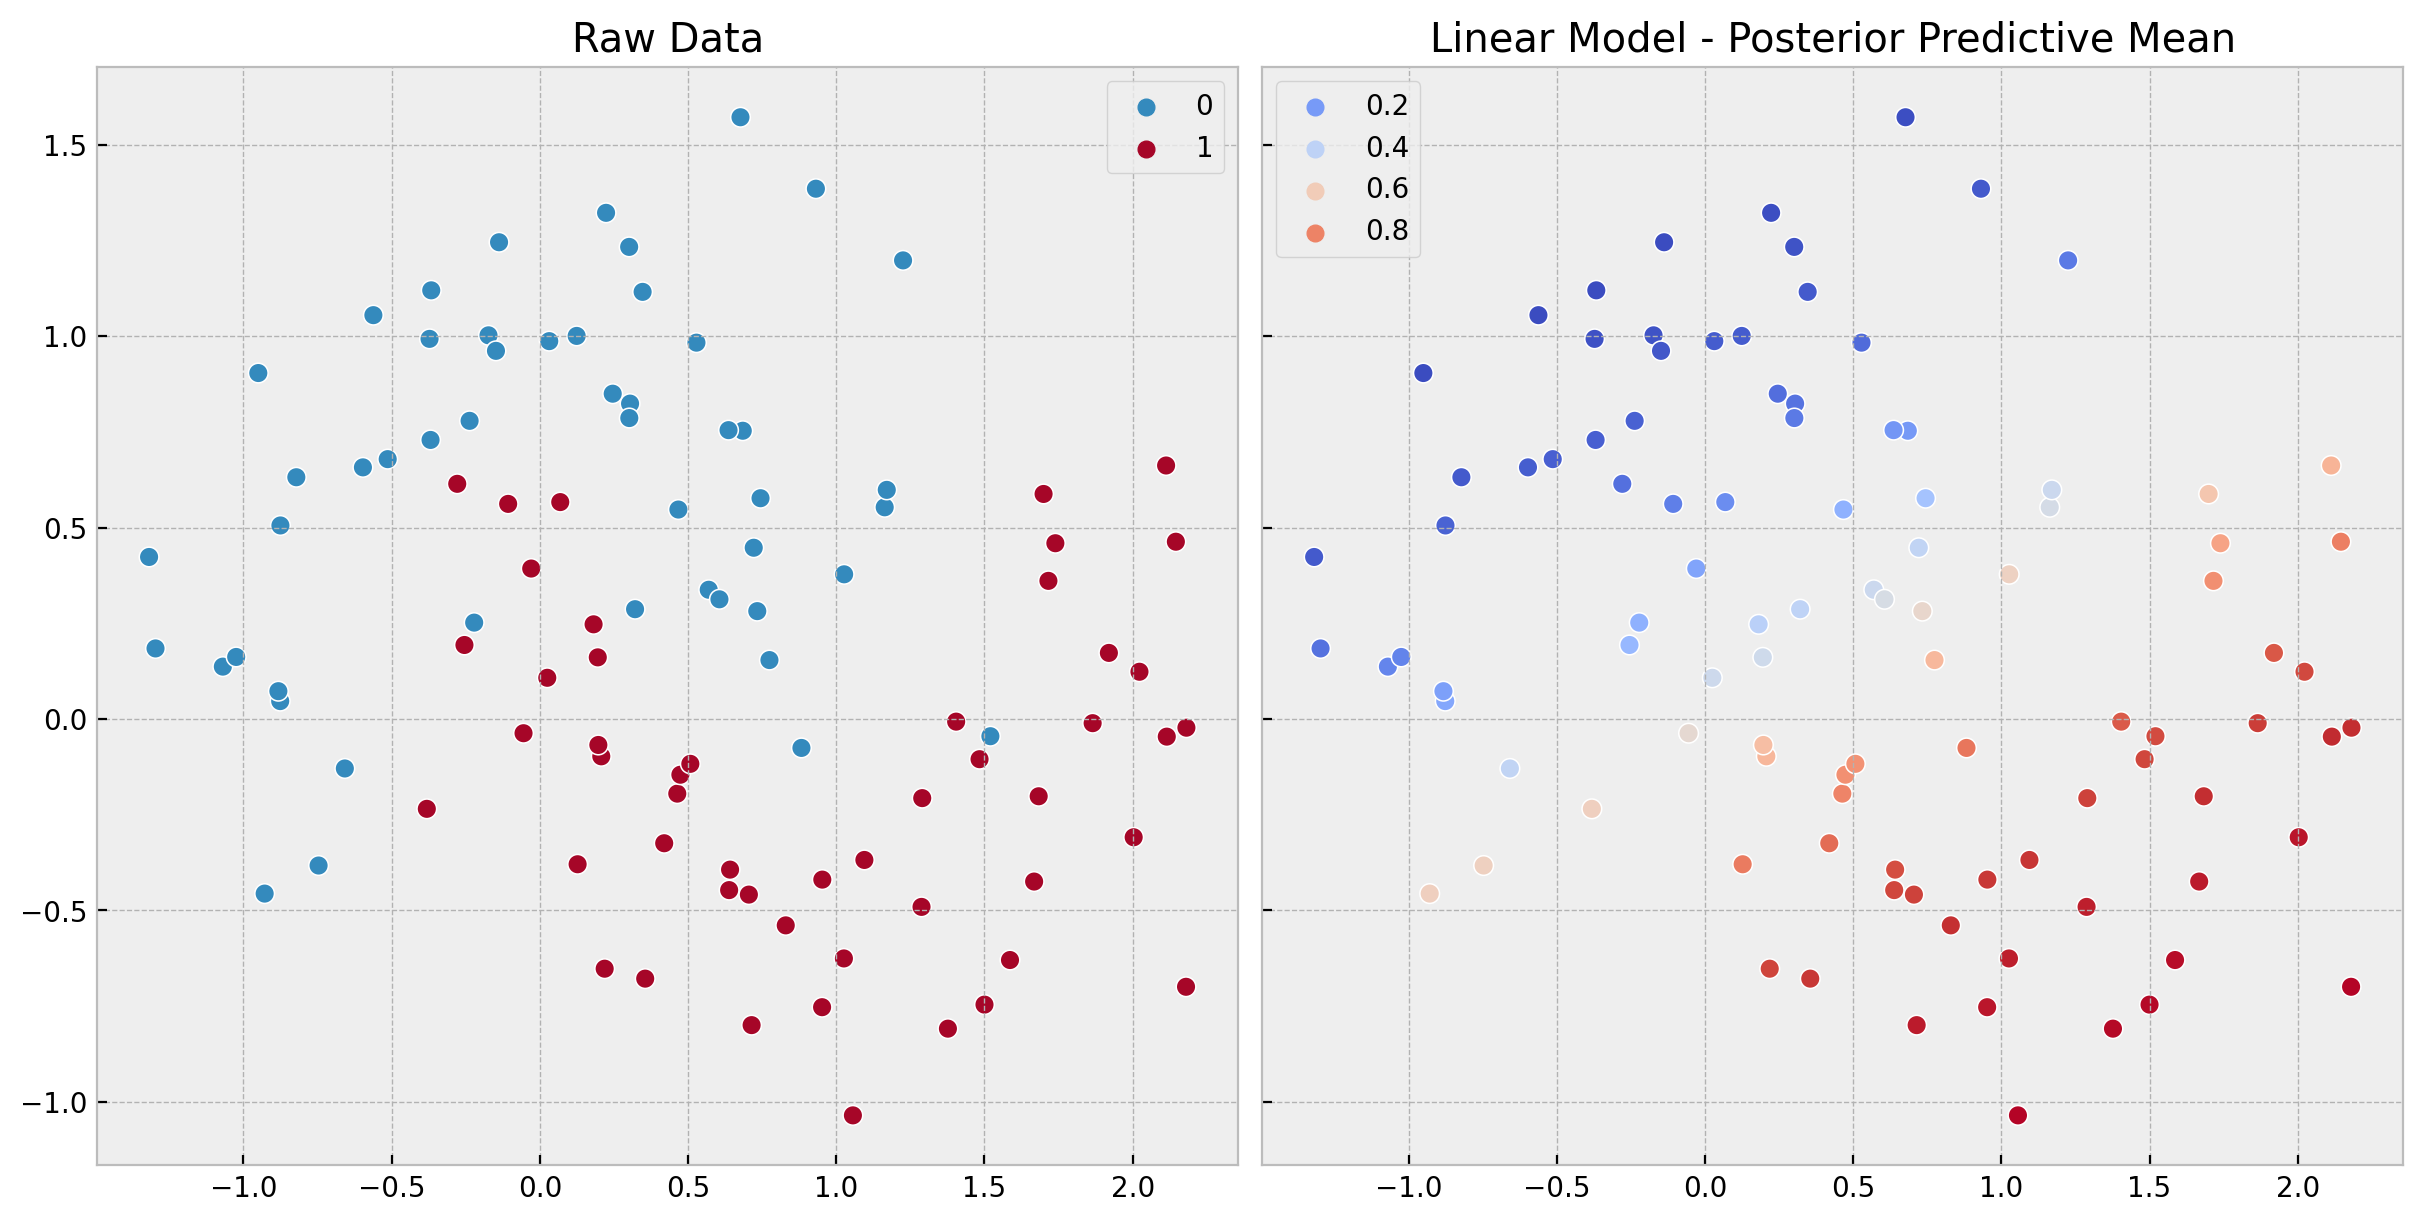

In [9]:
linear_posterior_predictive_mean = (
    linear_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, hue=y, ax=ax[0])
ax[0].set(title="Raw Data")

sns.scatterplot(
    x=x[:, 0],
    y=x[:, 1],
    s=50,
    hue=linear_posterior_predictive_mean,
    palette="coolwarm",
    ax=ax[1],
)
ax[1].legend(loc="upper left")
ax[1].set(title="Linear Model - Posterior Predictive Mean");

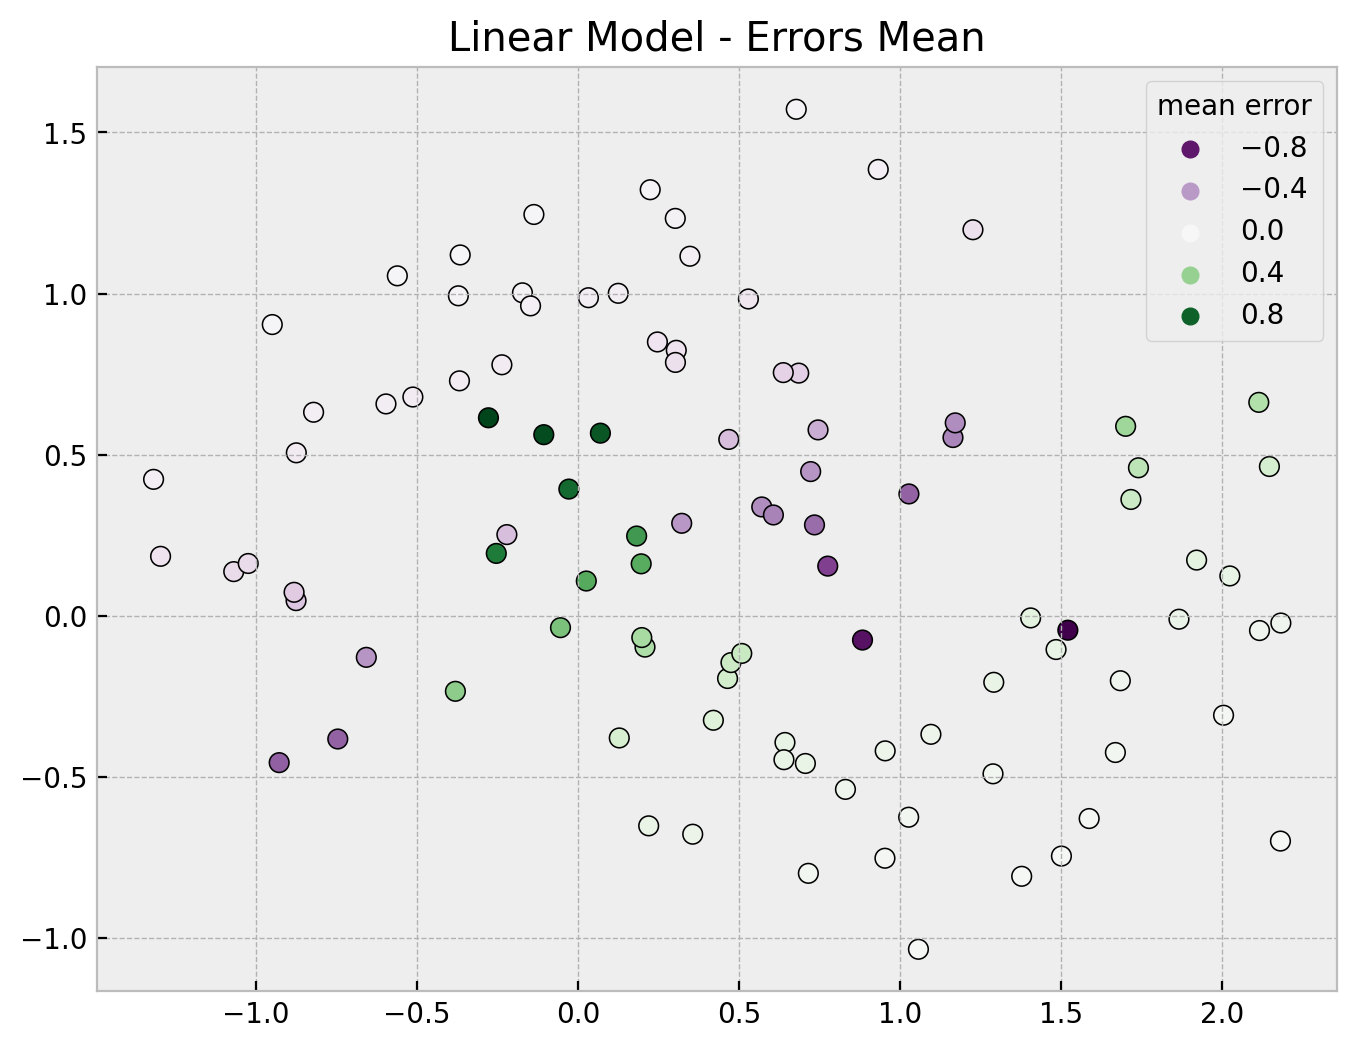

In [10]:
linear_errors_mean = (
    y[..., None] - linear_posterior_predictive.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, edgecolor="black", hue=linear_errors_mean, palette="PRGn", ax=ax)
ax.legend(title="mean error")
ax.set(title="Linear Model - Errors Mean");

## Gaussian Process

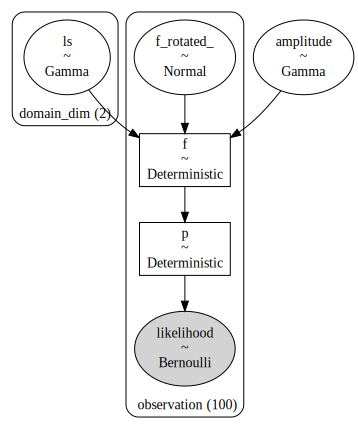

In [65]:
with pm.Model(coords=coords) as gp_model:

    ls = pm.Gamma(name="ls", alpha=2, beta=1, dims="domain_dim")
    amplitude = pm.Gamma(name="amplitude", alpha=2, beta=1)
    cov = amplitude ** 2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

    gp= pm.gp.Latent(cov_func=cov)
    f = gp.prior(name="f", X=x, dims="observation")
    p = pm.Deterministic(name="p", var=pm.math.sigmoid(f), dims="observation")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="observation", observed=y)

pm.model_to_graphviz(model=gp_model)

In [66]:
with gp_model:
    gp_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    gp_posterior_predictive = pm.sample_posterior_predictive(trace=gp_idata)

Compiling...
Compilation time =  0:00:03.273825
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:02:46.548213
Transforming variables...
Transformation time =  0:00:32.456782
Computing Log Likelihood...
Log Likelihood time =  0:00:22.083376


In [67]:
az.summary(data=gp_idata, var_names=["ls", "amplitude"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls[0],0.667,0.142,0.413,0.937,0.001,0.001,11853.0,11689.0,1.0
ls[1],1.271,0.489,0.484,2.173,0.005,0.003,10001.0,8183.0,1.0
amplitude,5.731,1.714,2.893,8.984,0.014,0.010,15322.0,12743.0,1.0


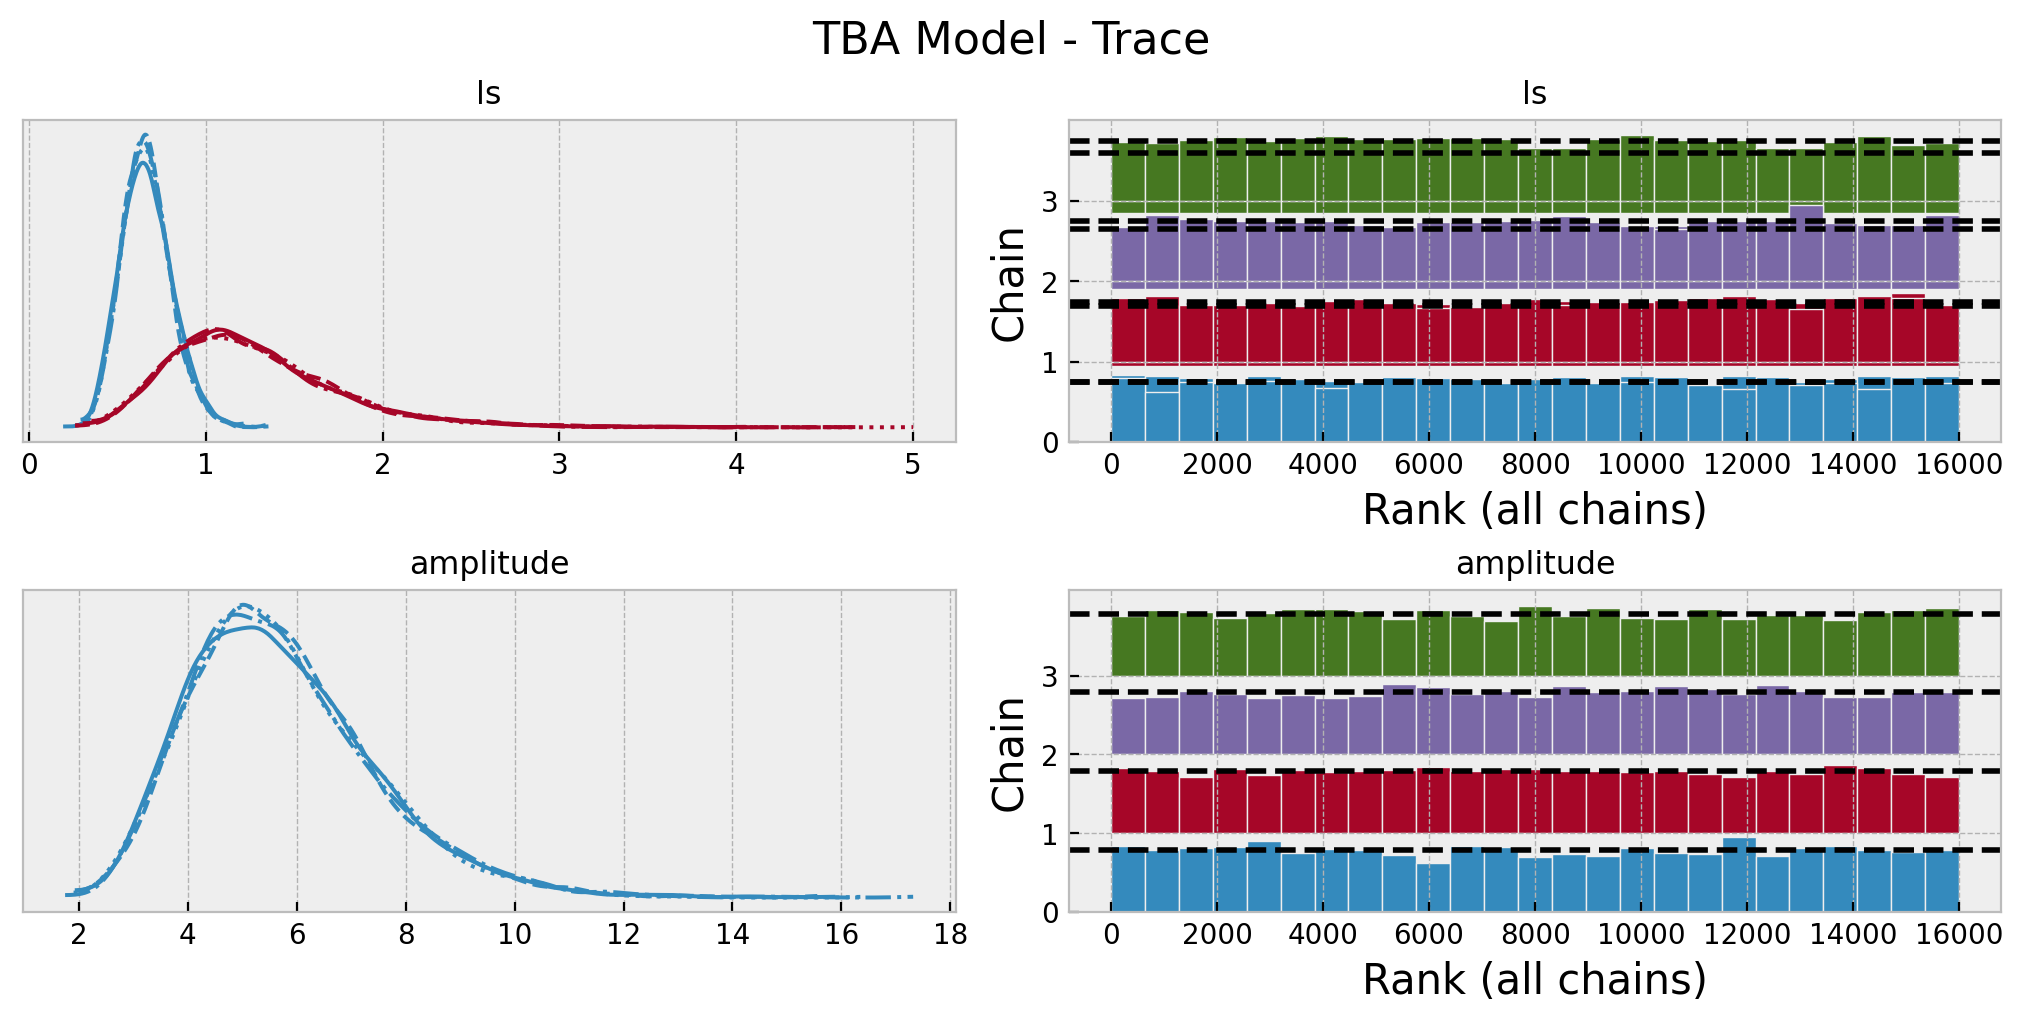

In [68]:
axes = az.plot_trace(
    data=gp_idata,
    var_names=["ls", "amplitude"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("TBA Model - Trace", fontsize=16);

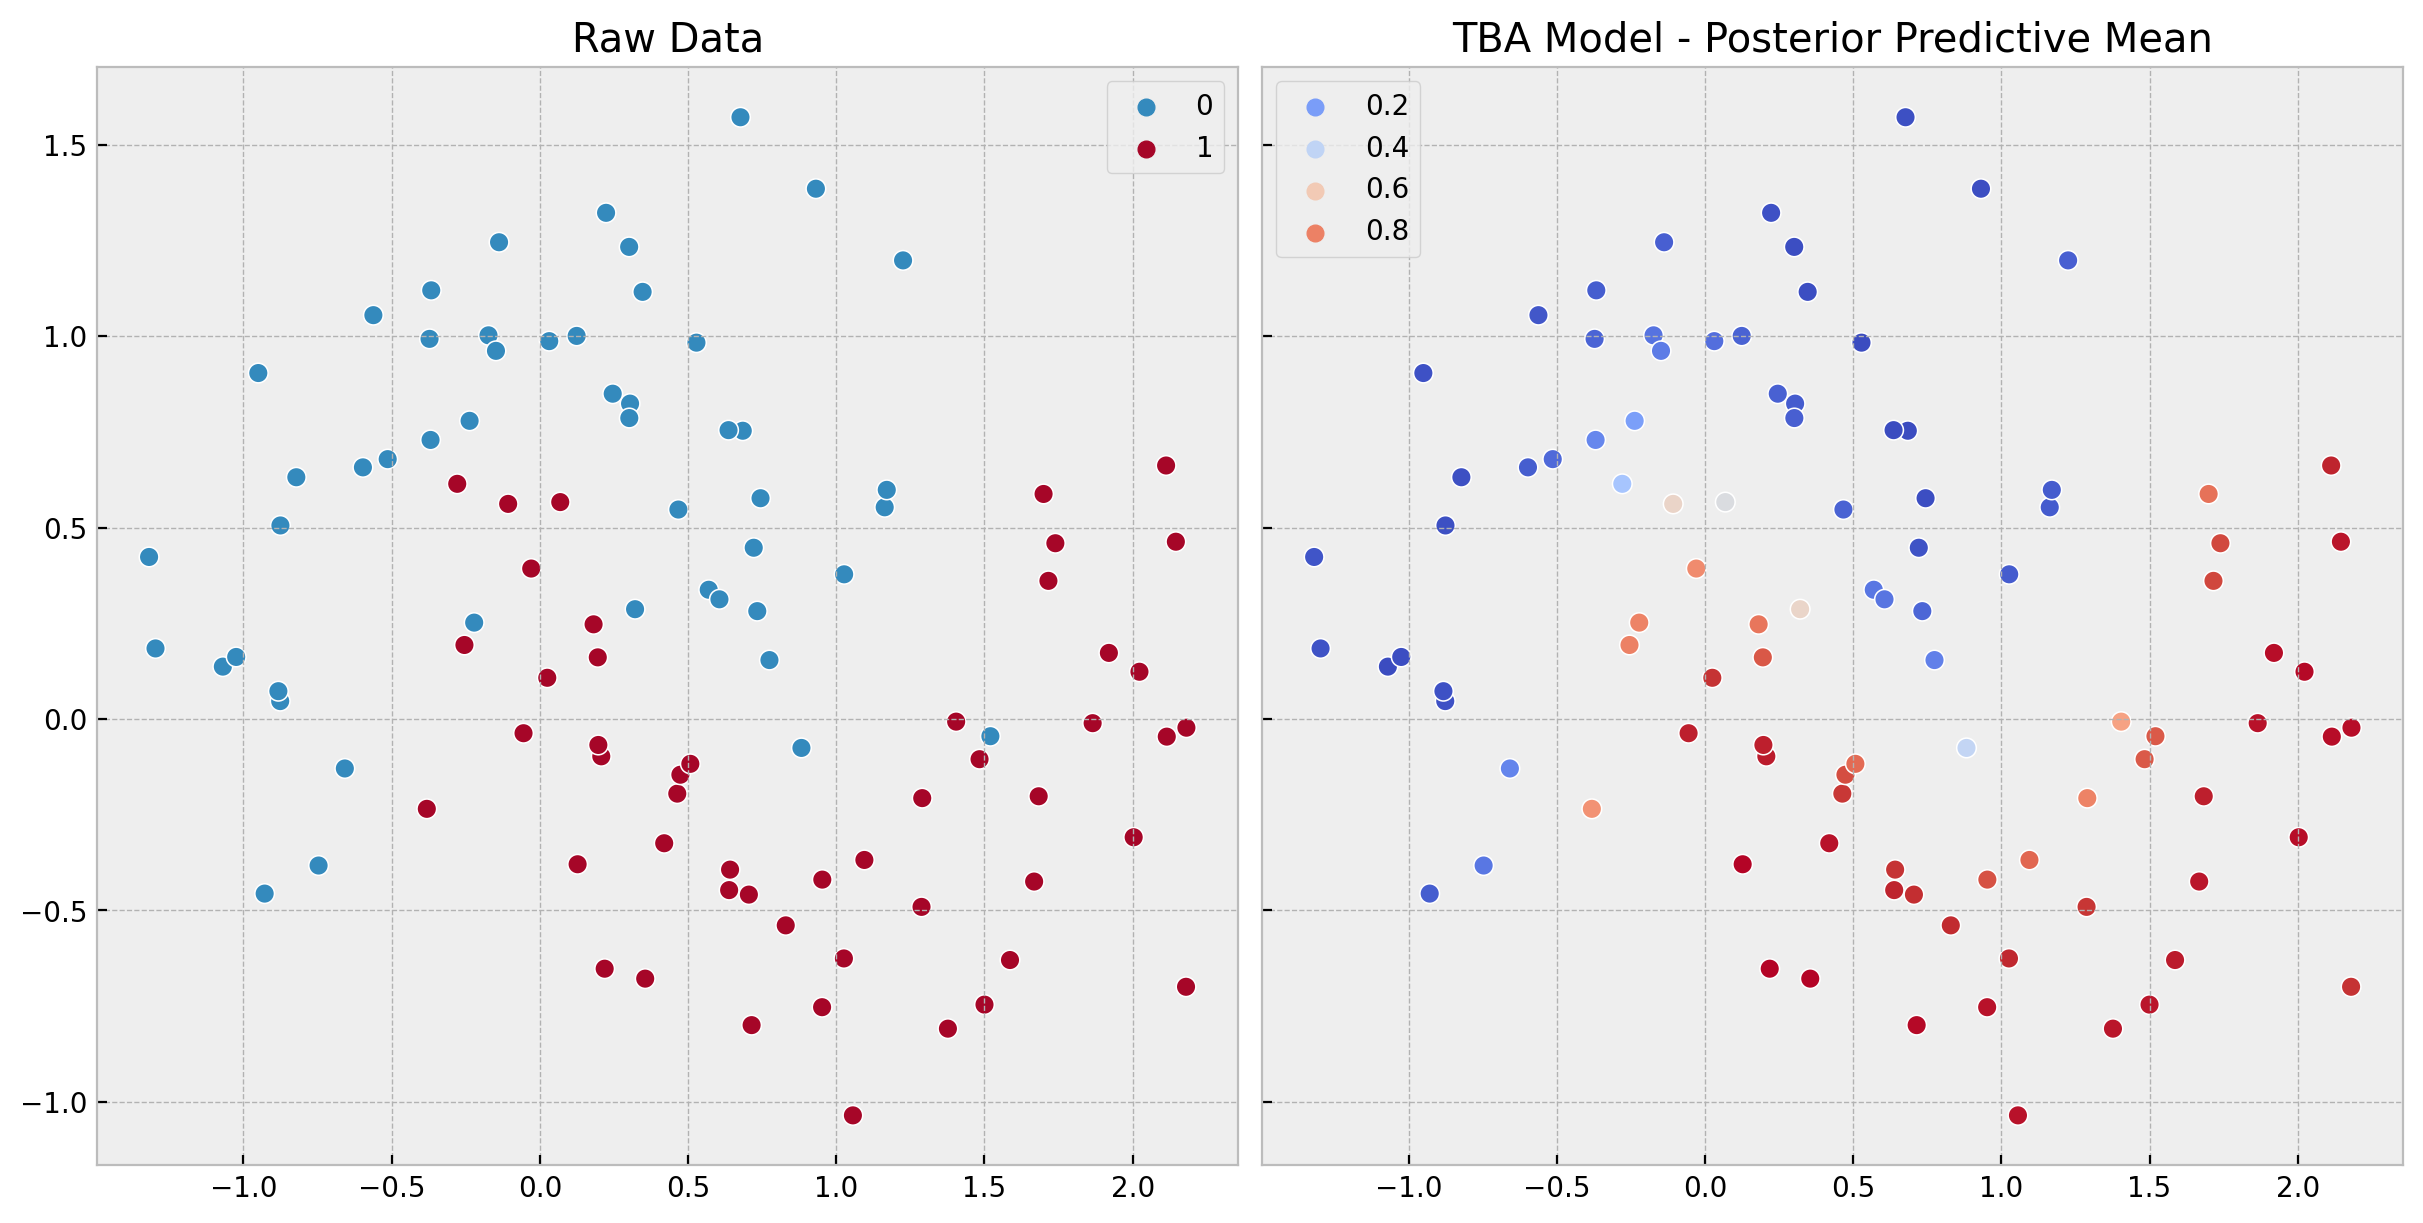

In [69]:
gp_posterior_predictive_mean = (
    gp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, hue=y, ax=ax[0])
ax[0].set(title="Raw Data")

sns.scatterplot(
    x=x[:, 0],
    y=x[:, 1],
    s=50,
    hue=gp_posterior_predictive_mean,
    palette="coolwarm",
    ax=ax[1],
)
ax[1].legend(loc="upper left")
ax[1].set(title="TBA Model - Posterior Predictive Mean");

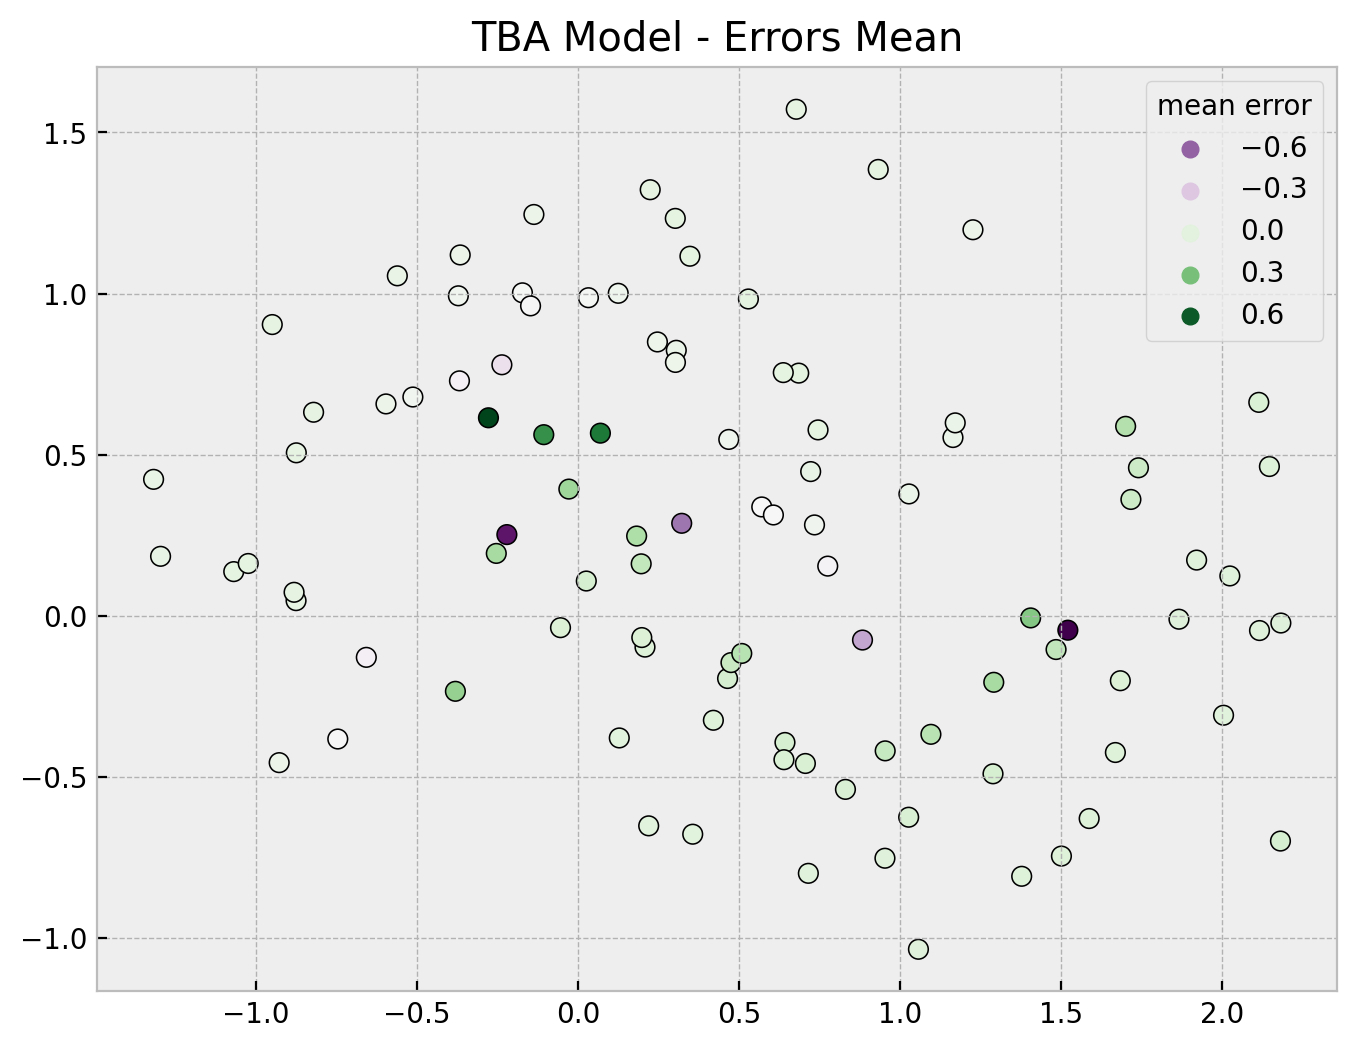

In [70]:
gp_errors_mean = (
    y[..., None] - gp_posterior_predictive.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, edgecolor="black", hue=gp_errors_mean, palette="PRGn", ax=ax)
ax.legend(title="mean error")
ax.set(title="TBA Model - Errors Mean");

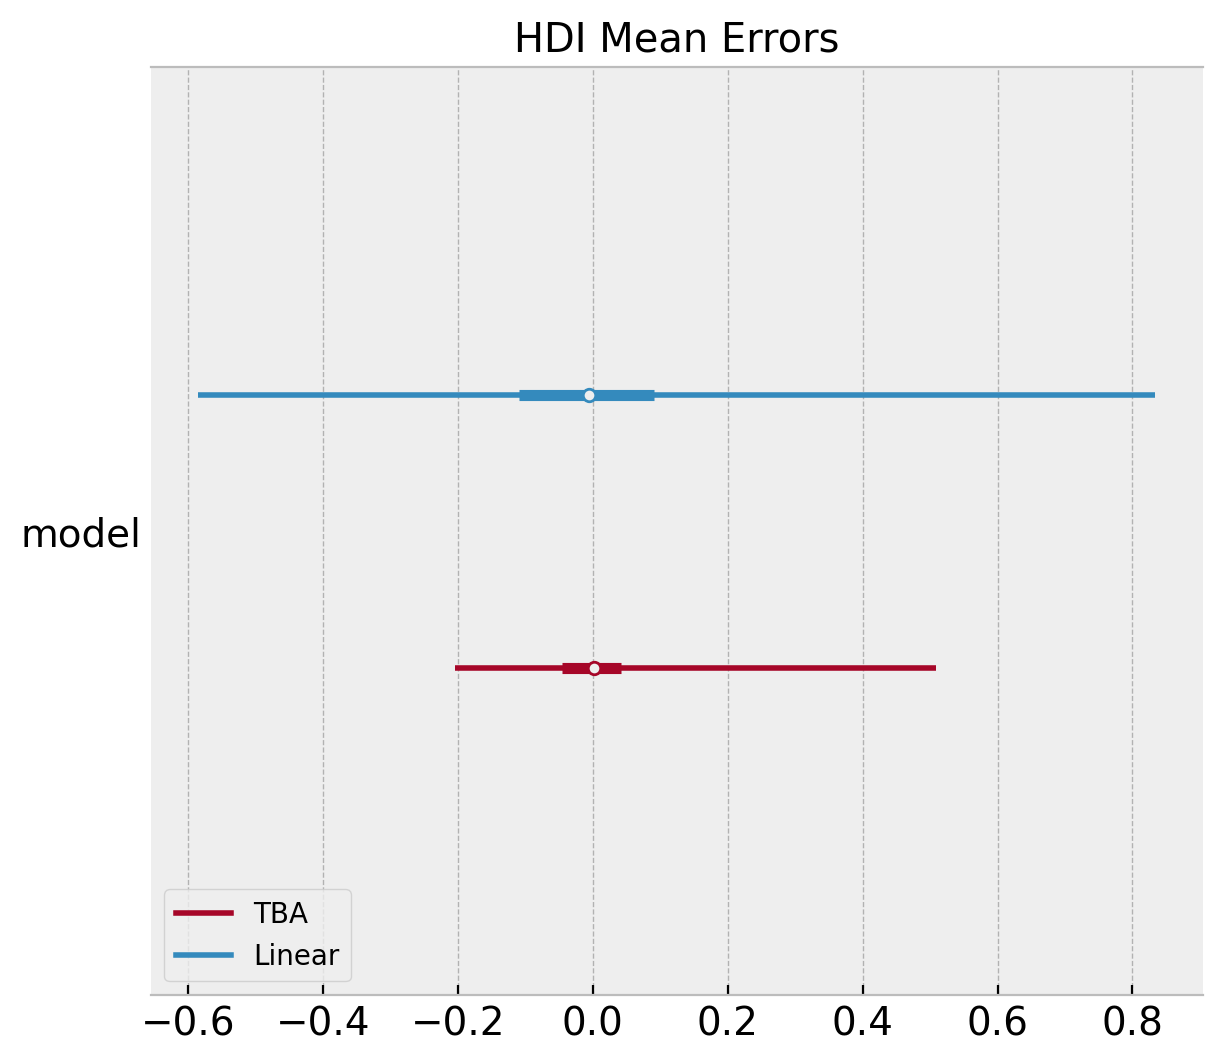

In [71]:
ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"model": linear_errors_mean.to_numpy()}),
        az.convert_to_dataset(obj={"model": gp_errors_mean.to_numpy()}),
    ],
    model_names=["Linear", "TBA"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="HDI Mean Errors");

In [131]:
az.compare(compare_dict={"Linear": linear_idata, "TBA": gp_idata})

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
TBA,0,-19.004293,5.477355,0.000000,1.0,4.824163,0.000000,True,log
Linear,1,-36.333630,2.232657,17.329337,0.0,5.382546,4.473722,False,log


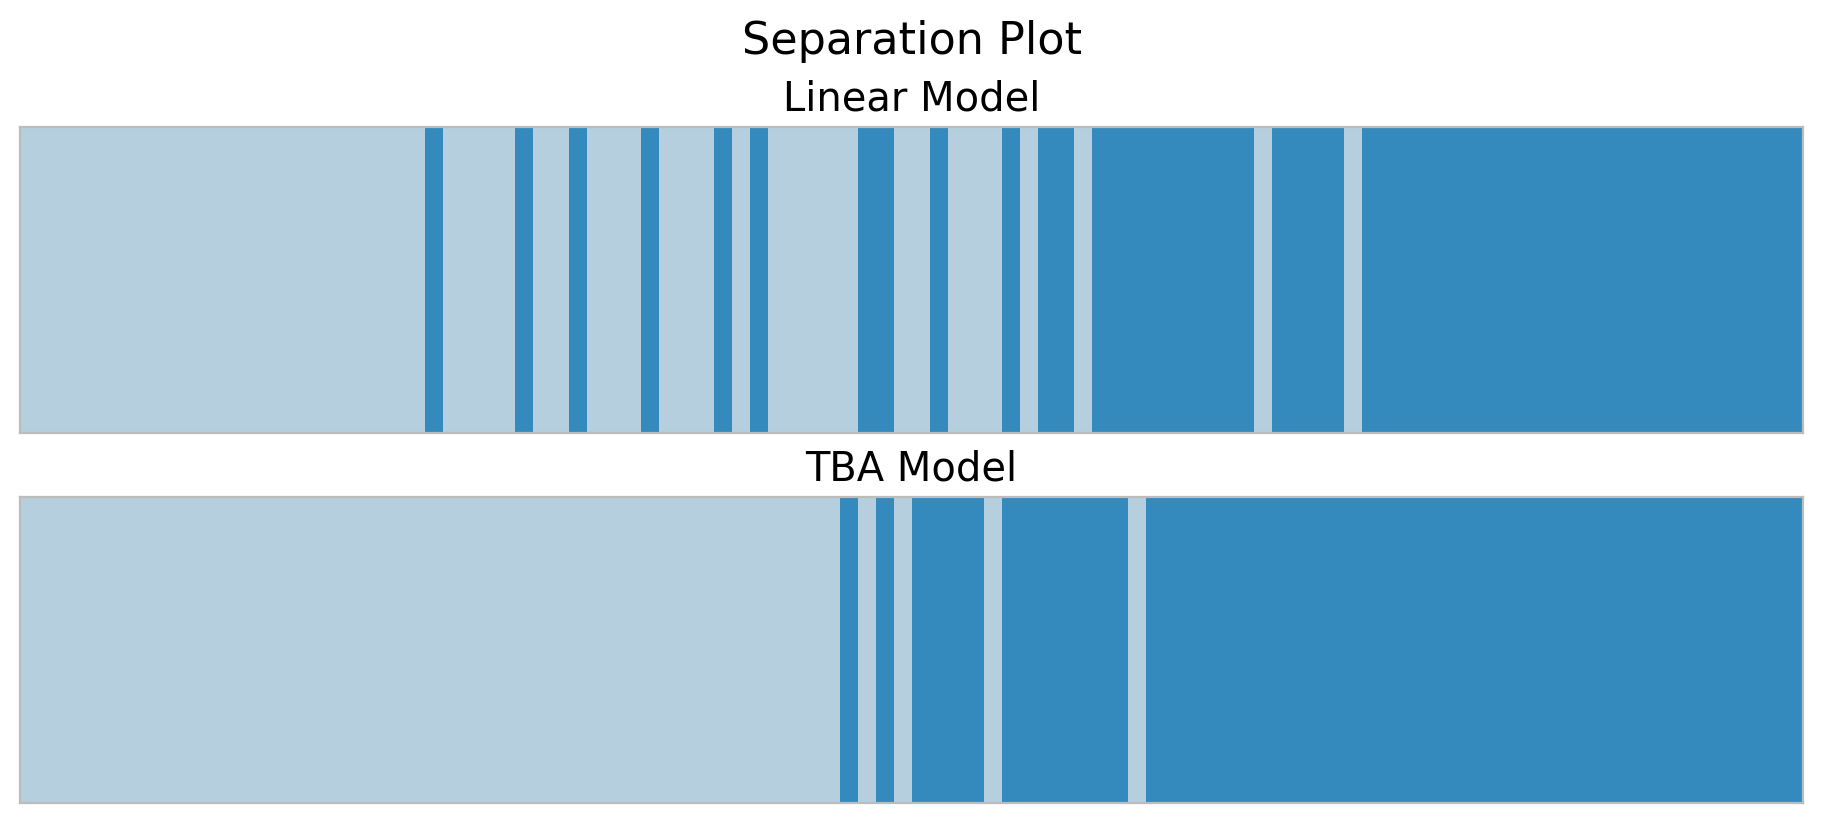

In [149]:
fig, ax = plt.subplots(
        nrows=2, ncols=1, figsize=(9, 4), layout="constrained"
)
az.plot_separation(idata=linear_posterior_predictive, y="likelihood", ax=ax[0])
ax[0].set(title="Linear Model")
az.plot_separation(idata=gp_posterior_predictive, y="likelihood", ax=ax[1])
ax[1].set(title="TBA Model")
fig.suptitle("Separation Plot", fontsize=16);